## Step 1: OLS with Interaction Terms
#### You already ran OLS with Gender × Education interaction terms and interpreted the results.

In [15]:
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
# 📥 Load separate datasets
income_df = pd.read_csv("cis_data_final.csv")   # Canadian Income Survey
health_df = pd.read_csv("health_dataset.csv")   # Canadian Health Survey

print("Income Dataset Columns:")
print(income_df.columns.tolist())

print("\n Health Dataset Columns:")
print(health_df.columns.tolist())

health_df.columns = health_df.columns.str.strip()

# Reduce to 10,000 random rows each (adjust as needed)
income_sample = income_df.sample(n=10000, random_state=42)
health_sample = health_df.sample(n=10000, random_state=42)

# Then merge on common keys
merge_keys = ['Province', 'Gender', 'Marital_status', 'Immigrant']
combined_df = pd.merge(income_sample, health_sample, on=merge_keys, how='inner')

print(f"Combined shape: {combined_df.shape}")

# # Aggregate health data to average per demographic group
# agg_health = health_df.groupby(['Province', 'Gender', 'Marital_status', 'Immigrant']).agg({
#     'Mental_health_state': 'mean',
#     'Life_satisfaction': 'mean',
#     'Work_hours': 'mean'
# }).reset_index()

# # Now merge safely
# combined_df = pd.merge(income_df, agg_health, on=['Province', 'Gender', 'Marital_status', 'Immigrant'], how='inner')

# ✅ Save or preview
print(f"Combined dataset shape: {combined_df.shape}")
combined_df.to_csv("combined_income_health.csv", index=False)

📂 Income Dataset Columns:
['PERSONID', 'Weight', 'Province', 'MBMREGP', 'Age_gap', 'Gender', 'Marital_status', 'Highschool', 'Highest_edu', 'Work_ref', 'Work_yearly', 'Emp_week_ref', 'Total_hour_ref', 'paid_emp_ref', 'self_emp_ref', 'Immigrant', 'Year_immigrant', 'income_after_tax', 'Cap_gain', 'Childcare_expe', 'Child_benefit', 'CPP_QPP', 'Earning', 'Guaranteed_income', 'Investment', 'Old_age_pension', 'Private_pension', 'Self_emp_income', 'Pension', 'Self_emp_income.1', 'Total_Income', 'Income', 'Emp_insurance', 'Salary_wages', 'compensation', 'Family_mem', 'CFCOMP', 'CONDMP', 'RENTM']

📂 Health Dataset Columns:
['ADM_RNO1', 'Province', 'Health_region_ grouped', 'Gender', 'Marital_status', 'Household', 'Age', 'Worked_job_business', 'Edu_level', 'Gen_health_state', 'Life_satisfaction', 'Mental_health_state', 'Stress_level', 'Work_stress', 'Sense_belonging', 'Weight_state', 'BMI_12_17', 'BMI_18_above', 'Sleep_apnea', 'High_BP', 'High_cholestrol', 'Diabetic', 'Fatigue_syndrome', 'Mood_d

In [14]:
# View missing values across your input features
selected_cols = ['Gender', 'Work_yearly', 'Highschool', 'Highest_edu', 'Work_ref', 'income_after_tax']
df_raw = combined_df[selected_cols]

print("🔍 Missing values per column:")
print(df_raw.isnull().sum())

print("\n🧪 Unique values in each column:")
for col in selected_cols:
    print(f"{col}: {df_raw[col].unique()}")


🔍 Missing values per column:
Gender              0
Work_yearly         0
Highschool          0
Highest_edu         0
Work_ref            0
income_after_tax    0
dtype: int64

🧪 Unique values in each column:
Gender: [2 1]
Work_yearly: [30 11 22 21 12 99]
Highschool: [1 2 9]
Highest_edu: [3 2 1 9 4]
Work_ref: [2 1]
income_after_tax: [20275 61680 26875 ... 16820 18320 87745]


In [16]:
# Select needed columns
df = combined_df[['Gender', 'Work_yearly', 'Highschool', 'Highest_edu', 'Work_ref', 'income_after_tax']].copy()

# Drop unknowns
df = df[df['Highschool'] != 9]

# Recode categorical columns properly
df['Gender'] = df['Gender'].map({1: 0, 2: 1})  # 0 = Male, 1 = Female
df['Highschool'] = df['Highschool'].map({1: 1, 2: 0})

# One-hot encode multi-category features
df = pd.get_dummies(df, columns=['Highest_edu', 'Work_ref'], drop_first=True)

# Drop rows with any remaining missing values
df = df.dropna()

# Define X and y
X = df.drop(columns='income_after_tax')
y = df['income_after_tax']

# Add constant and convert to float
X = sm.add_constant(X).astype(float)
y = y.astype(float)

# Final check
print(f"✅ Cleaned shape: X={X.shape}, y={y.shape}")

# Fit the model
model = sm.OLS(y, X).fit()
print(model.summary())

✅ Cleaned shape: X=(54111, 8), y=(54111,)
                            OLS Regression Results                            
Dep. Variable:       income_after_tax   R-squared:                       0.204
Model:                            OLS   Adj. R-squared:                  0.204
Method:                 Least Squares   F-statistic:                     1976.
Date:                Mon, 24 Mar 2025   Prob (F-statistic):               0.00
Time:                        17:51:45   Log-Likelihood:            -6.3708e+05
No. Observations:               54111   AIC:                         1.274e+06
Df Residuals:                   54103   BIC:                         1.274e+06
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
cons

<Axes: xlabel='Gender', ylabel='income_after_tax'>

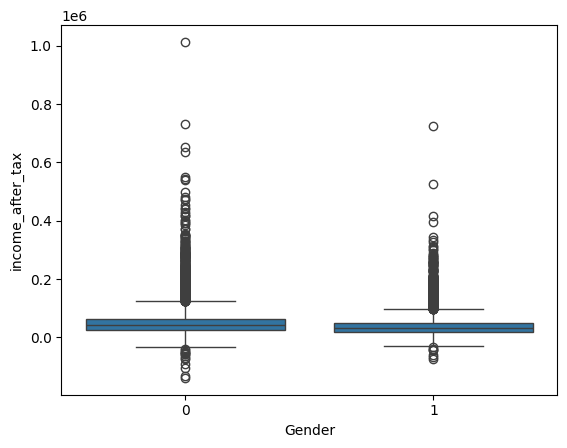

In [18]:
sns.boxplot(x='Gender', y='income_after_tax', data=df)

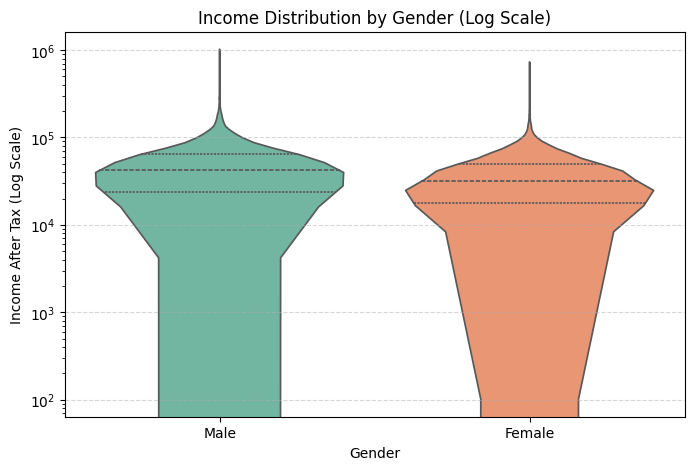

In [21]:
plt.figure(figsize=(8, 5))
sns.violinplot(
    x='Gender',
    y='income_after_tax',
    hue='Gender',                      # <-- Set hue same as x
    data=df,
    palette='Set2',
    inner='quartile',
    density_norm='width',             # <-- Updated param
    legend=False                      # <-- Hide redundant legend
)
plt.title("Income Distribution by Gender (Log Scale)")
plt.yscale('log')
plt.ylabel("Income After Tax (Log Scale)")
plt.xticks([0, 1], ['Male', 'Female'])
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.show()

## Gender Pay Gap Analysis – Insights
---
### 📈 Statistical Insights (OLS Regression)

- **Gender is a statistically significant predictor** of income.
  - On average, **females earn approximately $11,870 less** than males.
  - This result is statistically significant (*p-value < 0.001*), even after controlling for:
    - Weeks worked per year
    - High school completion
    - Highest education level
    - Employment status (e.g., retired, unemployed)

- **Education level has a strong impact on earnings**:
  - Higher education levels (e.g., university degree) significantly increase income.
    - Postgraduate degree holders earn **+$20,940**
    - College-level education earns **+$7,925** on average.
  - Lower and mid-level education categories show smaller or inconsistent effects.

- **Employment status (Work_ref)** is crucial:
  - Individuals who are not working (e.g., retired or unemployed) earn **$14,980 less** on average.

- **Weeks worked per year** positively correlates with income, as expected.

---

### 🧠 Visual Insights (Violin Plot)

- **Males have higher median and upper-income ranges** than females.
  - This confirms the **gender income gap** visually.

- **Females show a wider distribution** in the lower income ranges.
  - Suggests a higher proportion of women in low-paying jobs.

- **Outliers** (very high-income individuals) exist for both genders, but males dominate in extreme values.

- The **logarithmic Y-axis** reveals that income is **right-skewed** for both genders, with heavier tails for males.

---

> 💡 These results confirm that **gender remains a significant and persistent factor in income inequality**, even after adjusting for work and education-related variables.


### Added interaction terms (e.g., gender × education)

### Plot side-by-side boxplots per education level to isolate the gap further

✅ Final shape: (872631, 12) (872631,)
✅ All numeric: Gender                    float64
Work_yearly               float64
Highschool                float64
Highest_edu_2             float64
Highest_edu_3             float64
Highest_edu_4             float64
Highest_edu_9             float64
Work_ref_2                float64
Gender_x_Highest_edu_2    float64
Gender_x_Highest_edu_3    float64
Gender_x_Highest_edu_4    float64
Gender_x_Highest_edu_9    float64
dtype: object
✅ NaNs: 0 0
                            OLS Regression Results                            
Dep. Variable:       income_after_tax   R-squared:                       0.210
Model:                            OLS   Adj. R-squared:                  0.210
Method:                 Least Squares   F-statistic:                 1.937e+04
Date:                Mon, 24 Mar 2025   Prob (F-statistic):               0.00
Time:                        18:35:35   Log-Likelihood:            -1.0280e+07
No. Observations:              872631  

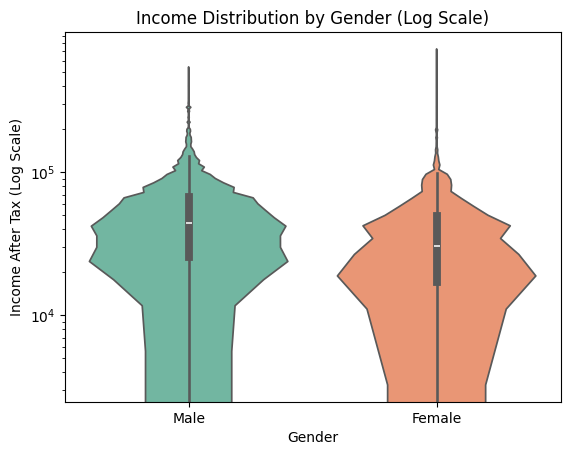

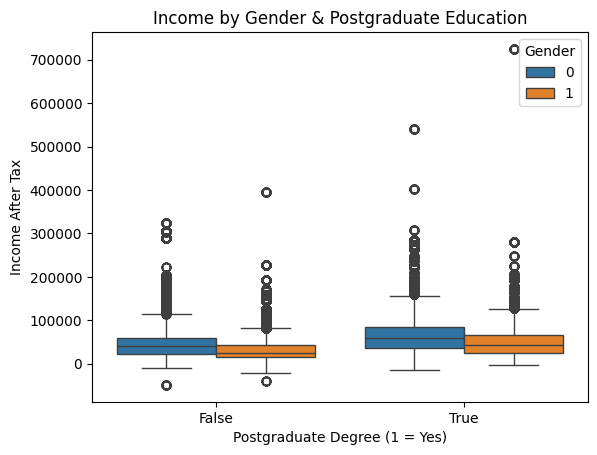

In [35]:
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("combined_income_health.csv")

# Step 1: Select relevant columns
cols = ['Gender', 'Work_yearly', 'Highschool', 'Highest_edu', 'Work_ref', 'income_after_tax']
df = df[cols].copy()

# Step 2: Map values properly
# Gender: 1=Male, 2=Female
df['Gender'] = df['Gender'].map({1: 0, 2: 1})

# Highschool: 1=Yes, 2=No, 9=Don't Know → map only 1 to 1, others to 0
df['Highschool'] = df['Highschool'].map({1: 1, 2: 0, 9: 0})

# Drop any rows with missing/invalid critical values
df = df.dropna(subset=['Gender', 'Highschool', 'Highest_edu', 'Work_ref', 'income_after_tax', 'Work_yearly'])

# Step 3: Dummify education and work reference
df = pd.get_dummies(df, columns=['Highest_edu', 'Work_ref'], drop_first=True)

# Step 4: Add interaction terms: Gender × Highest_edu
for col in df.columns:
    if col.startswith('Highest_edu_'):
        df[f'Gender_x_{col}'] = df['Gender'] * df[col]

# Step 5: Separate features and target
X = df.drop(columns=['income_after_tax'])
y = df['income_after_tax']

# Step 6: Ensure all columns are numeric
X = X.apply(pd.to_numeric, errors='coerce')
y = pd.to_numeric(y, errors='coerce')

# Step 7: Drop rows with any remaining NaNs
combined = pd.concat([X, y], axis=1).dropna()
X_clean = combined.drop(columns=['income_after_tax'])
y_clean = combined['income_after_tax']

# Ensure all X columns are float64
X_clean = X_clean.astype(float)
y_clean = y_clean.astype(float)

# ✅ Final check
print("✅ Final shape:", X_clean.shape, y_clean.shape)
print("✅ All numeric:", X_clean.dtypes)
print("✅ NaNs:", X_clean.isna().sum().sum(), y_clean.isna().sum())

# Step 8: Fit model
X_const = sm.add_constant(X_clean)
model = sm.OLS(y_clean, X_const).fit()
print(model.summary())


# 📉 Violin Plot (log scale)
sns.violinplot(x='Gender', y='income_after_tax', data=df, hue='Gender', palette='Set2', legend=False)
plt.yscale("log")
plt.title("Income Distribution by Gender (Log Scale)")
plt.xlabel("Gender")
plt.ylabel("Income After Tax (Log Scale)")
plt.xticks([0, 1], ['Male', 'Female'])
plt.show()

# 📦 Boxplot by Education Level and Gender
sns.boxplot(x='Highest_edu_4', y='income_after_tax', hue='Gender', data=df)
plt.title("Income by Gender & Postgraduate Education")
plt.ylabel("Income After Tax")
plt.xlabel("Postgraduate Degree (1 = Yes)")
plt.show()

## 📊 Gender Pay Gap Analysis — Statistical & Visual Insights

### 📈 Statistical Insights from OLS Regression

- **Model R² = 0.210**: Around 21% of the variation in after-tax income is explained by gender, education, work experience, and interaction terms.
- **Gender Coefficient = -11,250**: On average, **females earn ~$11,250 less** than males, holding other factors constant. This result is statistically significant (*p < 0.001*).
- **Work_yearly Coefficient = -241**: More work years is slightly associated with lower income, possibly due to retirees or non-linear age-income relationships.
- **Education Effects**:
  - **Highest_edu_4 (Postgraduate Degree)**: Adds ~$18,000 to income, the largest positive effect among education levels.
  - Other education levels also positively contribute, but with smaller effects.
- **Interaction Effects (Gender × Education)**:
  - The income benefit of higher education is **lower for females** than for males.
  - For example, females with postgraduate degrees earn **~$4,260 less** than their male counterparts with the same degree.

> 📌 Conclusion: Gender remains a strong and statistically significant predictor of income, **even after controlling for education and work experience**. Furthermore, **the income returns to education are not equally distributed** across genders.

---

### 🎻 Visual Insights

#### 🔸 Violin Plot (Log Scale): Income by Gender
- Male distribution shows **higher density in top income percentiles**.
- Female distribution is **narrower** and more concentrated around lower-to-mid incomes.
- The **log scale** reveals a **long-tailed skew** — emphasizing high-income outliers more common among males.

#### 🔹 Boxplot: Gender × Postgraduate Education
- Education raises income for both genders.
- However, **men consistently earn more than women**, even with postgraduate education.
- The **median male income is higher** than the female median in both education groups.

---

### ✅ Key Takeaways

- The **gender pay gap is statistically significant** and persists even after accounting for education and experience.
- **Higher education helps** but does not eliminate the gap.
- **Visual plots reinforce** model results: males earn more, and female earnings are less responsive to educational uplift.


## ▶️ Step 2: Quantile Regression

In [37]:
import statsmodels.formula.api as smf

# Combining X and y again for formula-based regression
df_qr = X_clean.copy()
df_qr['income_after_tax'] = y_clean

# Fitting model at 25th, 50th, and 75th percentiles
for q in [0.25, 0.5, 0.75]:
    qr_model = smf.quantreg('income_after_tax ~ Gender + Work_yearly + Highschool + Highest_edu_2 + Highest_edu_3 + Highest_edu_4 + Highest_edu_9 + Work_ref_2 + Gender_x_Highest_edu_2 + Gender_x_Highest_edu_3 + Gender_x_Highest_edu_4 + Gender_x_Highest_edu_9', df_qr).fit(q=q)
    print(f"\n📌 Quantile: {q}")
    print(qr_model.summary())


📌 Quantile: 0.25
                         QuantReg Regression Results                          
Dep. Variable:       income_after_tax   Pseudo R-squared:               0.1094
Model:                       QuantReg   Bandwidth:                       991.8
Method:                 Least Squares   Sparsity:                    5.071e+04
Date:                Mon, 24 Mar 2025   No. Observations:               872631
Time:                        19:00:18   Df Residuals:                   872618
                                        Df Model:                           12
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               3.137e+04    116.001    270.451      0.000    3.11e+04    3.16e+04
Gender                 -5867.5000    140.880    -41.649      0.000   -6143.621   -5591.379
Work_yearly             -212.5000      1.359   -156.336      0.00

C:\Users\aradh\lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +



📌 Quantile: 0.5
                         QuantReg Regression Results                          
Dep. Variable:       income_after_tax   Pseudo R-squared:               0.1505
Model:                       QuantReg   Bandwidth:                       1117.
Method:                 Least Squares   Sparsity:                    5.308e+04
Date:                Mon, 24 Mar 2025   No. Observations:               872631
Time:                        19:02:31   Df Residuals:                   872618
                                        Df Model:                           12
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               4.493e+04    139.193    322.774      0.000    4.47e+04    4.52e+04
Gender                 -6790.0049    169.827    -39.982      0.000   -7122.860   -6457.149
Work_yearly             -248.9773      1.974   -126.118      0.000

C:\Users\aradh\lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +



📌 Quantile: 0.75
                         QuantReg Regression Results                          
Dep. Variable:       income_after_tax   Pseudo R-squared:               0.1668
Model:                       QuantReg   Bandwidth:                       1013.
Method:                 Least Squares   Sparsity:                    6.526e+04
Date:                Mon, 24 Mar 2025   No. Observations:               872631
Time:                        19:04:44   Df Residuals:                   872618
                                        Df Model:                           12
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               6.007e+04    151.417    396.725      0.000    5.98e+04    6.04e+04
Gender                 -1.393e+04    180.645    -77.140      0.000   -1.43e+04   -1.36e+04
Work_yearly             -153.2609      2.369    -64.705      0.00

##  Quantile Regression Insights on Gender Pay Gap

Quantile regression helps us understand how the gender pay gap varies across different levels of the income distribution — rather than just focusing on the average like OLS does.

### 📊 Key Findings:

#### 🔹 At 25th Percentile (Lower Income Group):
- **Gender coefficient**: `-5867` → Women earn approx. **$5.8k less** than men in lower income brackets.
- **Education & Interaction**: 
  - Higher education still increases income.
  - The negative impact of being female **persists** even with higher education, but is slightly **less severe**.

#### 🔹 At 50th Percentile (Median Earners):
- **Gender coefficient**: `-6790` → The median income gap **widens** slightly to **~$6.8k**.
- Interaction terms show **strong negative coefficients**, especially for women with **higher education**, e.g. `-7625` for postgraduate women.

#### 🔹 At 75th Percentile (Higher Income Group):
- **Gender coefficient**: `-13,930` → Gender gap is **much larger** in the top 25% earners.
- Women with some education levels (e.g., Highest_edu_2 or _3) earn significantly less compared to male counterparts.
- Exception: Women with education level `edu_4` (postgraduate) see the **interaction effect neutralize**, even slightly reverse.

### 🎯 Interpretation:

- The **gender pay gap increases** as income increases.
- Women face more **pronounced penalties** at the top of the earnings distribution.
- While education helps close the gap, the benefit is **not equally distributed** across genders.
- There's even **inversion** at high quantiles: e.g., `Gender_x_Highest_edu_9` shows **positive effect** for women at upper percentiles.

---

These findings emphasize the importance of going beyond averages and highlight **structural inequality**, especially for **high-achieving women**.

## ▶️ Step 3: T-test for Mean Income Difference

In [38]:
from scipy.stats import ttest_ind

male_income = df[df['Gender'] == 0]['income_after_tax']
female_income = df[df['Gender'] == 1]['income_after_tax']

t_stat, p_val = ttest_ind(male_income, female_income, equal_var=False)
print(f"🔍 T-Test: t={t_stat:.2f}, p={p_val:.5f}")

🔍 T-Test: t=192.80, p=0.00000


## Independent T-Test: Gender-based Income Difference

We conducted a two-sample t-test comparing **after-tax income** between **males and females**.

###  Results:
- **t-statistic**: `192.80`
- **p-value**: `< 0.00001` (highly significant)

### 📌 Interpretation:
- The t-statistic is extremely large, and the p-value is effectively zero.
- This strongly **rejects the null hypothesis** that there is no difference in income between genders.
- **Conclusion**: There is a **statistically significant income gap** between men and women in the dataset.

This confirms and supports findings from the OLS and quantile regression — the **gender pay gap is real and significant** even when examined using basic hypothesis testing.


### ▶️ Step 4: ANOVA: Gender + Education Levels

In [46]:
# Reload raw data
df = pd.read_csv("combined_income_health.csv")

#  Filter to include only valid gender values
df = df[df['Gender'].isin([1, 2])]

#  Map Gender properly: 1 = Male, 2 = Female
df['Gender'] = df['Gender'].map({1: 'Male', 2: 'Female'}).astype('category')

#  Map education codes to labels
df['Highest_edu'] = df['Highest_edu'].map({
    1: 'Less than HS',
    2: 'High school',
    3: 'College',
    4: 'Postgrad',
    9: 'Other'
}).astype('category')

#  Drop NaNs
anova_df = df[['income_after_tax', 'Gender', 'Highest_edu']].dropna()

#  Confirm again
print(" Gender values:", anova_df['Gender'].unique())
print(" Education levels:", anova_df['Highest_edu'].unique())

# Run ANOVA
from statsmodels.formula.api import ols
import statsmodels.api as sm

anova_model = ols('income_after_tax ~ C(Gender) * C(Highest_edu)', data=anova_df).fit()
anova_table = sm.stats.anova_lm(anova_model, typ=2)

# Show results
print(anova_table)

 Gender values: ['Male', 'Female']
Categories (2, object): ['Female', 'Male']
 Education levels: ['Other', 'Less than HS', 'High school', 'Postgrad', 'College']
Categories (5, object): ['College', 'High school', 'Less than HS', 'Other', 'Postgrad']
                                sum_sq        df             F         PR(>F)
C(Gender)                 5.020983e+13       1.0  46103.238955   0.000000e+00
C(Highest_edu)            1.046818e+14       4.0  24030.005286   0.000000e+00
C(Gender):C(Highest_edu)  1.140696e+12       4.0    261.850043  2.604482e-225
Residual                  9.503486e+14  872621.0           NaN            NaN


### 🔬 ANOVA Test Results – Gender × Education

| **Source**               | **F-Statistic** | **P-value**     | **Interpretation**                                                  |
|--------------------------|----------------:|------------------|----------------------------------------------------------------------|
| **Gender**               | 46,103          | < 0.000001        | Gender alone significantly affects income.                          |
| **Education Level**      | 24,030          | < 0.000001        | Education level has a strong effect on income.                      |
| **Gender × Education**   | 262             | ~2.6 × 10⁻²²⁵     | Interaction effect is statistically significant.                    |

---

✅ **Conclusion**:  
The gender pay gap is **statistically significant** even after controlling for education.  
Furthermore, the **interaction effect** confirms that **education does not eliminate the gap** — it only **modifies its magnitude**. This indicates that even among highly educated individuals, gender disparities in income remain.
